In [15]:
from qgis.core import QgsVectorLayer,QgsField,edit
from qgis.PyQt.QtCore import QVariant

#for developing
import geopandas as gpd
import matplotlib.pyplot as plt

<AxesSubplot:>

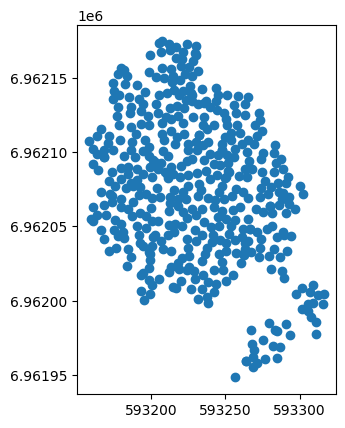

In [4]:
#example cutting area
data_example = "data_example\ReTreeT.gpkg"
layer = "treemap"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"treemap","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [5]:
data_df

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,MEANHEIGHTDECIDUOUS,MEANHEIGHTPINE,MEANHEIGHTSPRUCE,PaajakoNro,Nimi,Nimi_2,leimikko,DTW_1,euc_1,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,NaN,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.068761,52.0,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,NaN,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.047743,44.0,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,NaN,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.060228,46.0,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,NaN,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.049569,48.0,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,NaN,15.71,6.00,2,Eteläboreaalinen vyöhyke,None,1.0,0.055280,45.0,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,10.1,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.506014,106.0,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,10.1,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.343525,100.0,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,10.1,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.310039,98.0,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,10.1,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.385177,103.0,POINT (593244.375 6962084.625)


In [16]:
def normalizeValue(in_feat:QgsVectorLayer,fieldname:str):
    """
    This normalize values between 0 and 1 by formula f(x) = x-min(x) / max(x) - min(x)
    """
    in_feat.dataProvider().addAttributes([QgsField(fieldname+"n",QVariant.Double)])
    in_feat.updateFields()
    lis = [feat[fieldname] for feat in in_feat.getFeatures() if feat[fieldname] is not None]
    try:
        minlis = min(lis)
        maxlis = max(lis)
    except:
        minlis = 0
        maxlis = 1

    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if feat[fieldname] is not None:
                feat[fieldname+"n"] = (feat[fieldname]-minlis) / (maxlis-minlis)
            else:
                feat[fieldname+"n"] = 0.0
            
            in_feat.updateFeature(feat)


In [17]:
normalizeValue(data_qgis,"DTW_1")

data_df = gpd.read_file(data_example,layer = layer)
data_df

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,MEANHEIGHTPINE,MEANHEIGHTSPRUCE,PaajakoNro,Nimi,Nimi_2,leimikko,DTW_1,euc_1,DTW_1n,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.068761,52.0,0.010111,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.047743,44.0,0.007020,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.060228,46.0,0.008856,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,9.26,NaN,2,Eteläboreaalinen vyöhyke,None,1.0,0.049569,48.0,0.007289,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,15.71,6.00,2,Eteläboreaalinen vyöhyke,None,1.0,0.055280,45.0,0.008129,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.506014,106.0,0.074406,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.343525,100.0,0.050513,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.310039,98.0,0.045589,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,20.93,19.79,2,Eteläboreaalinen vyöhyke,None,1.0,0.385177,103.0,0.056638,POINT (593244.375 6962084.625)


(array([387.,   7.,   9.,   9.,   3.,  15.,   6.,   5.,   1.,   3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

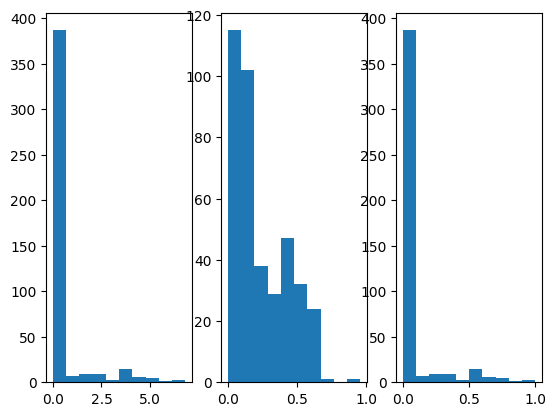

In [47]:
plt.subplot(1,3,1)
plt.hist(data_df["DTW_1"])

plt.subplot(1,3,2)
plt.hist(data_df["DTW_1"].where(data_df["DTW_1"]<1))

plt.subplot(1,3,3)
plt.hist(data_df["DTW_1n"])

In [30]:
def simpson_di(data):
    """
    This calculates simpson diversity index by formula D = n(n-1)/N(N-1)
    Species list are form of [10,1,3,4]
    """
    N = sum(n for n  in data if type(n) == int or type(n) == float)
    n = sum(n*(n-1) for n in data if type(n) == int or type(n) == float)
    if N-1 < 1:
        d = 0
    else:
        d = 1 - (float(n)/(N*(N-1)))
    return d

In [43]:
def calculateBiodiversity(in_feat:QgsVectorLayer,speciesfield:list):
    
    in_feat.dataProvider().addAttributes([QgsField("biod",QVariant.Double)])
    in_feat.updateFields()
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            
            sim_di = simpson_di([feat[i]/1000*256 for i in speciesfield if feat[i] > 0])
            if feat['SPECIALFEATURECODE'] is not None:
                conver_cof = sim_di * 0.1
            else:
                conver_cof = 0
            
            feat['biod'] = float(sim_di+conver_cof)
            in_feat.updateFeature(feat)
    
    normalizeValue(in_feat,'biod')

In [44]:
calculateBiodiversity(data_qgis,["STEMCOUNTPINE","STEMCOUNTDECIDUOUS","STEMCOUNTSPRUCE"])


data_df = gpd.read_file(data_example,layer = layer)
data_df

,CHM,SPECIALFEATURECODE,SPECIALFEATUREADDITIONALCODE,FERTILITYCLASS,DEVELOPMENTCLASS,STEMCOUNTPINE,STEMCOUNTDECIDUOUS,STEMCOUNTSPRUCE,MEANDIAMETERDECIDUOUS,MEANDIAMETERPINE,...,PaajakoNro,Nimi,Nimi_2,leimikko,DTW_1,euc_1,DTW_1n,biod,biodn,geometry
0,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.068761,52.0,0.010111,0.000000,0.000000,POINT (593161.000 6962063.000)
1,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.047743,44.0,0.007020,0.000000,0.000000,POINT (593161.000 6962053.500)
2,81,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.060228,46.0,0.008856,0.000000,0.000000,POINT (593159.500 6962055.000)
3,97,None,None,4,02,1453.0,NaN,NaN,NaN,11.46,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.049569,48.0,0.007289,0.000000,0.000000,POINT (593163.500 6962057.500)
4,144,None,None,4,03,1168.0,NaN,10.0,NaN,16.59,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.055280,45.0,0.008129,0.018579,0.025352,POINT (593179.857 6962051.500)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,169,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.506014,106.0,0.074406,0.337514,0.460561,POINT (593235.500 6962094.500)
441,218,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.343525,100.0,0.050513,0.337514,0.460561,POINT (593236.833 6962087.389)
442,227,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.310039,98.0,0.045589,0.337514,0.460561,POINT (593239.389 6962082.167)
443,220,None,None,4,03,478.0,7.0,101.0,7.5,23.24,...,2,Eteläboreaalinen vyöhyke,None,1.0,0.385177,103.0,0.056638,0.337514,0.460561,POINT (593244.375 6962084.625)


(array([70., 58., 60., 89., 28., 16., 22., 43., 33., 26.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

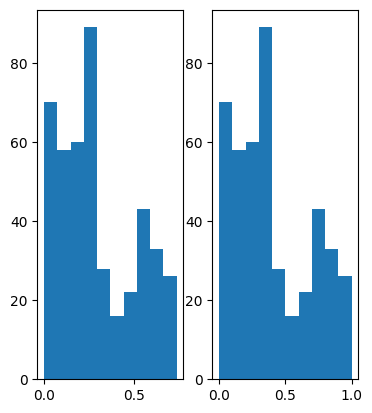

In [45]:
plt.subplot(1,3,1)
plt.hist(data_df["biod"])

plt.subplot(1,3,2)
plt.hist(data_df["biodn"])